In [3]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import json
from sqlalchemy import text
from src.db_connect import get_engine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Create engine
engine = get_engine()

In [7]:
df_customers = pd.read_sql(text('SELECT * FROM s_hamayunrahimzai.prep_customer_metrics;'), con=engine)
df_customers_insights = pd.read_sql(text('SELECT * FROM s_hamayunrahimzai.mart_customer_insights;'), con=engine)

In [8]:
# Select only the demographic columns we want to add from df_customers
demographics_to_add = df_customers[['customer_id','first_purchase_date', 'last_purchase_date' ]].copy()

# Merge the RFM insights with these selected customer demographics
# We use a 'left' merge to keep all customers from the insights table
merged_customer_data = pd.merge(
    df_customers_insights,
    demographics_to_add,
    on='customer_id',
    how='left'
)
merged_customer_data.head()

,customer_id,full_name,email,recency_days,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_total,customer_segment,first_purchase_date,last_purchase_date
0,100,Gilda Nurdiyanti,ed22ddc5_151b_4128_9590_de9b0bc8bfc6@startupca...,1088,2,227544.0,1,1,1,3,At Risk Customer,2016-08-15,2019-08-08
1,10000,Cakrabuana Ardianto,818ffe25_3914_4386_9449_d693a05264f1@zakyfound...,44,8,7178324.0,2,2,2,6,Loyal Customer,2021-07-22,2022-06-17
2,10001,Ella Suryatmi,8ae0c4fa_171a_466f_9863_64cbb22f956e@startupca...,81,11,10574864.0,2,2,2,6,Loyal Customer,2019-10-29,2022-05-11
3,10002,Labuh Santoso,2ca61485_e5f8_43f8_8000_df57c3d5da27@startupca...,220,3,918279.0,1,1,1,3,At Risk Customer,2020-10-05,2021-12-23
4,10003,Makara Sitompul,13fc2a1c_0582_4268_81f1_d8f6e4511904@startupca...,198,3,801299.0,1,1,1,3,At Risk Customer,2020-12-04,2022-01-14


In [16]:
# 1. Convert date column and define reference point
merged_customer_data['last_purchase_date'] = pd.to_datetime(merged_customer_data['last_purchase_date'])
today = pd.to_datetime("2022-07-31")  # Reference date based on your data


In [17]:
# 2. Calculate recency and churn flag
merged_customer_data['recency_days'] = (today - merged_customer_data['last_purchase_date']).dt.days
merged_customer_data['churn_flag'] = merged_customer_data['recency_days'].apply(lambda x: 1 if x > 90 else 0)


In [18]:
# 3. Churn rate by customer segment
churn_rate = merged_customer_data.groupby('customer_segment')['churn_flag'].mean().reset_index()
churn_rate.columns = ['Customer Segment', 'Churn Rate']
churn_rate['Churn Rate'] = churn_rate['Churn Rate'] * 100  # Convert to percentage


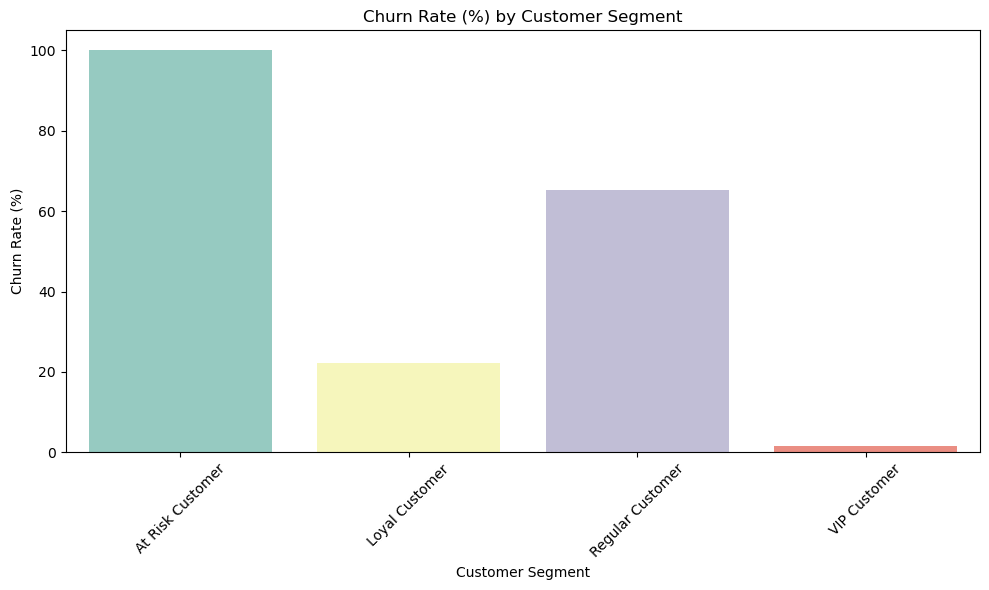

In [19]:
# 4. Plot churn rate
plt.figure(figsize=(10, 6))
sns.barplot(
    data=churn_rate,
    x='Customer Segment',
    y='Churn Rate',
    hue='Customer Segment',
    palette='Set3',
    dodge=False,
    legend=False
)
plt.title('Churn Rate (%) by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# Count of total and churned customers per segment
check_counts = merged_customer_data.groupby('customer_segment')['churn_flag'].agg(['count', 'sum'])
check_counts.columns = ['Total Customers', 'Churned Customers']
check_counts['Churn Rate (%)'] = (check_counts['Churned Customers'] / check_counts['Total Customers']) * 100
check_counts['Churn Rate (%)'] = check_counts['Churn Rate (%)'].map(lambda x: f"{x:.2f}".rstrip('0').rstrip('.') + '%')

print(check_counts)

                  Total Customers  Churned Customers Churn Rate (%)
customer_segment                                                   
At Risk Customer            17613              17613           100%
Loyal Customer               8768               1950         22.24%
Regular Customer            12025               7837         65.17%
VIP Customer                11836                186          1.57%


In [21]:
merged_customer_data[['customer_segment', 'last_purchase_date', 'recency_days', 'churn_flag']].sample(10)


,customer_segment,last_purchase_date,recency_days,churn_flag
11045,At Risk Customer,2021-11-26,247,1
35288,At Risk Customer,2021-05-26,431,1
16955,Regular Customer,2022-06-13,48,0
7283,VIP Customer,2022-07-10,21,0
27915,At Risk Customer,2020-09-20,679,1
42673,Regular Customer,2022-01-03,209,1
35759,Loyal Customer,2022-07-31,0,0
30763,VIP Customer,2022-07-11,20,0
30611,Loyal Customer,2022-06-20,41,0
40976,VIP Customer,2022-07-30,1,0


In [22]:
print(merged_customer_data['last_purchase_date'].isnull().sum())


0


In [26]:
summary = merged_customer_data.groupby('customer_segment').agg({
    'frequency': 'mean',
    'monetary': 'mean',
    'recency_days': 'mean'
}).reset_index()

print(summary)

   customer_segment  frequency      monetary  recency_days
0  At Risk Customer   1.945324  1.010088e+06    671.521944
1    Loyal Customer  13.418910  2.224654e+07     64.121921
2  Regular Customer   5.458046  8.347612e+06    192.692973
3      VIP Customer  50.558550  9.360693e+07     29.224738
